# Dopamine Neuron Pacemaking

Throughout the brain, populations of cells show a large array of activity patterns. Some cells, for example, are incredibly quiescent, only showing activity when they receive a volley of input from other parts of the brain. Other cells, such as the dopamine cells that I study, have activity patterns that include spontaneous firing (i.e. the production of spiking activity that occurs indepenently of synaptic input). 

For the dopamine neurons I study, this spontaneous activity is important for the overall role of providing dopaminergic input to other parts of the brain. Individuals with Parkinson's disease, which is associated with the death of these dopamine-producing cells, cannot initiate movement largely as a result of the loss of this dopaminergic input to various brain areas. 

The spontaneous firing of these cells can be modified by input from other brain regions. We know, for example, that excitatory input can drive these cells to show "bursts" of activity (i.e. a series of two or more spikes in rapid succession). Our lab thinks that these periods of high activity may be contributing to why these cells die in Parkinson's disease. 

Below I go through an experiment where I am recording the activity of a single dopamine neuron and stimulating it to observe changes in its firing pattern. 

In [1]:
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('../../neurphys/neurphys/')
import pv_import as pvi
import pacemaking as pace

%matplotlib inline

In [2]:
folder = './data/Cell1-Burst_protocol-001/'
df = pvi.import_folder(folder)['voltage recording']
df.head()

Time    Primary  Secondary    Bl led
Sweep     Index                                        
Sweep0001 0      0.0000 -48.638916 -12.207031 -0.000916
          1      0.0001 -48.706055  -8.544922 -0.000916
          2      0.0002 -48.675537  -9.155273 -0.000305
          3      0.0003 -48.724365  -6.713867 -0.000610
          4      0.0004 -48.687744 -11.596680 -0.000916

This dataset consists of one sweep, totaling a little over 5 minutes of recording time. We are using a stimulation paradigm where we use light (a blue LED) to activate excitatory synapses that provide input to these cells. 
Shown below is a subset of the data where we are applying a series of stimuli. Outside of the stimulus period the cell is firing regularly. We see within the stimulus period the cell depolarizes slightly (the trough of the spike does not go as negative), and there appears to be a small change in firing rate. Following the stimulation period we see a short delay, and then the cell resumes spiking normally.

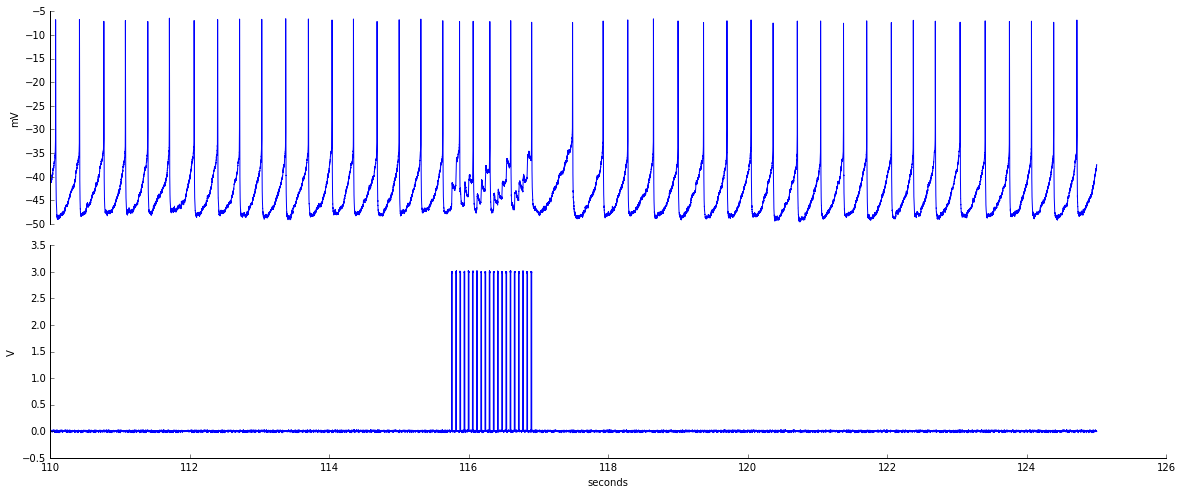

In [3]:
f, axes = plt.subplots(2, sharex=True, figsize=(20, 8))
axes[0].plot(df.Time.ix[1100000:1250000], df.Primary.ix[1100000:1250000])
axes[1].plot(df.Time.ix[1100000:1250000], df['Bl led'].ix[1100000:1250000])


for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

axes[0].spines['bottom'].set_visible(False)
axes[0].axes.get_xaxis().set_visible(False)

axes[0].set_ylabel('mV')
axes[1].set_ylabel('V')
axes[1].set_xlabel('seconds')
f.subplots_adjust(hspace=0.1)

Ultimately the goal is to calculate the average firing frequency outside and within the stimulation periods and compare the two. We use a relatively straightforward function that looks for peaks that cross a certain threshold (in this case, -15mV). Below we see that it has correctly identifid the spikes in this subregion. 

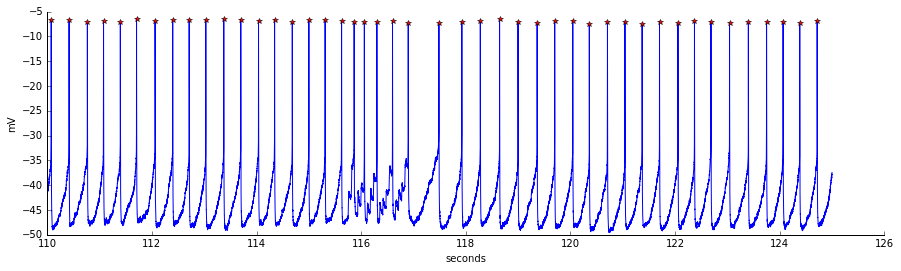

In [4]:
sub_df = df.ix[1100000:1250000]
_, indices = pace.calc_freq(sub_df, mph=-15, ret_indices=True)

fig = plt.figure(figsize=(15, 4))
plt.plot(sub_df.Time, sub_df.Primary)
plt.plot(sub_df.Time.ix[indices], sub_df.Primary.ix[indices], 'r*')
fig.axes[0].spines['top'].set_visible(False)
fig.axes[0].spines['right'].set_visible(False)
plt.tick_params(which='both', top='off', right='off')
plt.xlabel('seconds')
plt.ylabel('mV')
plt.show()

Over the entire recording, we repeat the stimulation protocol 15 times. The time between each stimulation period is 20 seconds. Here we calculate, based on the parameters of the stimulation (# of stimuli given within one epoch, duration of each stimulus, duration between stimuli), both the length of each stimulus epoch as well as the starts times for all of the stimulus epochs. We then use these values to find the frequencies for each of the stimulation epochs (again, 15 total). 

In [5]:
initial_delay = 10
num_pulses = 20
pulse_dur = 0.01
pulse_interval = 0.05
stim_interval = 20
num_bursts = 15

stim_length = num_pulses * pulse_dur + (num_pulses-1) * pulse_interval

start_times = [i*(stim_interval+stim_length) + initial_delay for i in range(num_bursts)]

Looking at the entire recording we see a very regular pattern: the stimulus produces a brief period of increased firing frequency, followed by a brief period after the stimulus where firing rate is depressed. The cell then returns to a regular firing rate until the next stimulus occurs. 

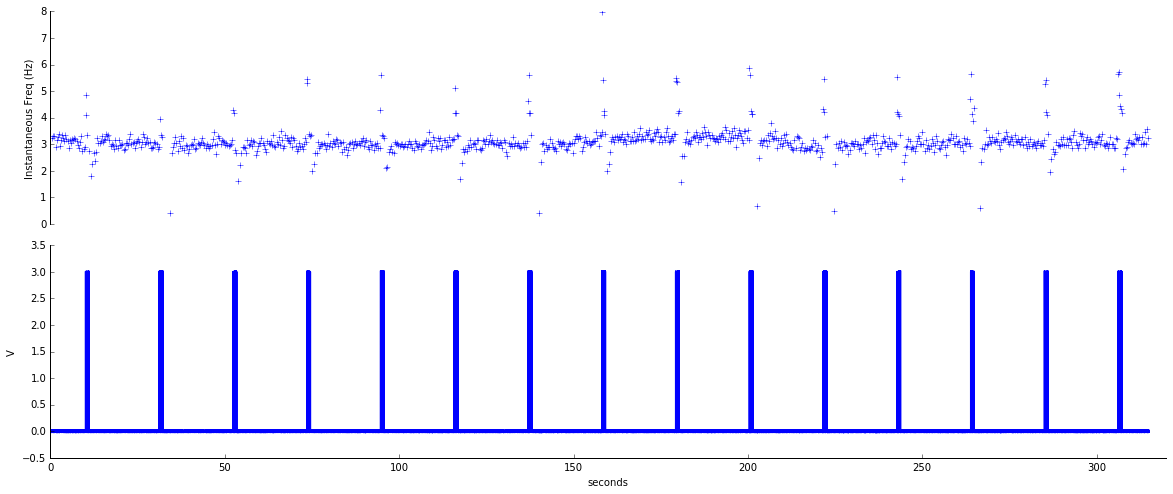

In [6]:
freq, times = pace.calc_freq(df, mph=-15, ret_times=True)
f, axes = plt.subplots(2, sharex=True, figsize=(20, 8))
axes[0].plot(times, freq, '+')
axes[1].plot(df.Time, df['Bl led'])
plt.xlim(0, 320)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

axes[0].spines['bottom'].set_visible(False)
axes[0].axes.get_xaxis().set_visible(False)

axes[0].set_ylabel('Instantaneous Freq (Hz)')
axes[1].set_ylabel('V')
axes[1].set_xlabel('seconds')
f.subplots_adjust(hspace=0.1)

Ultimately, we want to know what the firing rate within the stimulation period is in comparison to the baseline firing rate. We loop over the data set, calculating the instantanenous frequencies for a baseline region (defined as 5 second period ending 1 second before the beginning of each stimulus epoch) and the frequencies within the stimulation period. 

We then calculate an average value across all the baseline regions and all the stimulus epochs. We also calculate the average peak (highest) frequency across the stimulation epochs, since we generally see a rapid decrement in firing rate (a phenomenon called spike frequency adaptation) in these cells when stimulated. 

In [7]:
bsl_freqs = []
stim_freqs = []

for start_time in start_times:
    bsl_start = start_time - 6
    bsl_end = start_time - 1
    bsl_df = df[(df.Time >= bsl_start) & (df.Time <= bsl_end)]
    bsl_freqs.append(pace.calc_freq(bsl_df, mph=-15))
    
    stim_end = start_time + stim_length
    stim_df = df[(df.Time >= start_time) & (df.Time <= stim_end)]
    stim_freqs.append(pace.calc_freq(stim_df, mph=-15))

In [8]:
avg_bsl_freqs = [freq_array.mean() for freq_array in bsl_freqs]
avg_stim_freqs = [freq_array.mean() for freq_array in stim_freqs]
peak_stim_freqs = [freq_array.max() for freq_array in stim_freqs]

In [9]:
avg_bsl = sum(avg_bsl_freqs)/len(avg_bsl_freqs)
avg_stim = sum(avg_stim_freqs)/len(avg_stim_freqs)
avg_stim_peak = sum(peak_stim_freqs)/len(peak_stim_freqs)

In [10]:
print("""Avg baseline freq: {:0.3F}Hz
Avg stim freq: {:0.3F}Hz
Avg peak stim freq: {:0.3F}Hz""".format(avg_bsl, avg_stim, avg_stim_peak))


Avg baseline freq: 3.071Hz
Avg stim freq: 4.158Hz
Avg peak stim freq: 5.351Hz


### Summary
Overall, we see a small shift in average firing rate during the stimulation. This particular experiment was pilot work confirming that we could indeed affect firing rate with this particular type of stimulus. Ultimately, the goal of this line of experiments is to examine changes in cell health as a result of this stimulation paradigm. 